\newpage

# 0 Setup {-}

In [2]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# ignore tensorflow depreciation warnings
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

### 0.1 Visualizing the Dataset {-}

In [5]:
# given by the assignment
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data ["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

\newpage

In [6]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (15000, 28, 28)	Training tagets: (15000,)
Validation Data: (1000, 28, 28)	Validation tagets: (1000,)
Testing Data: (2724, 28, 28)	Testing tagets:(2724,)


In [7]:
def plot(image, target, ax=None):
    ax = plt.gca() if ax == None else ax
    ax.imshow(image, cmap="hot")
    target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    ax.set_title(target_names[target])
    # targets interger encoded from 0 to 9 corresponding to 'A' to 'J', respectively

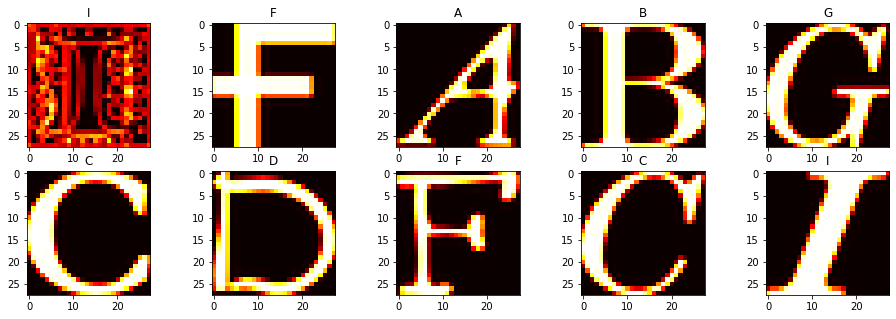

In [8]:
fig, axis = plt.subplots(2, 5, figsize=(16, 5))
for ax in axis.reshape(-1):
    r = np.random.randint(trainData.shape[0])
    plot(trainData[r], trainTarget[r], ax=ax)
plt.show()

\newpage

### 0.2 Useful Functions {-}

Some useful functions that will be used throughout the assignment such as getting random weights, getting the accuracy of a batch, making the loss and accuracy plots look nice, and global variables used throughout the code

In [9]:
# given by the assignment
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))
    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [10]:
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_loss != None:
        ax.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        ax.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        ax.plot(x, test_loss, label="Testing Loss")
    
    ax.set_title("Loss" if title == None else title)
    
    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper right")

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_accuracy != None:
        ax.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        ax.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        ax.plot(x, test_accuracy, label="Testing Accuracy")
    
    ax.set_title("Accuracy" if title == None else title)

    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Accuracy")
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.grid(linestyle='-', axis='y')
    ax.legend(loc="lower right")
    

def display_statistics(train_loss=None, train_acc=None, valid_loss=None, valid_acc=None, 
                       test_loss=None, test_acc=None):
    
    """
    tl == ["-"] if train_loss is None else [train_loss[-1]:.4f]
    ta == ["-"] if train_acc is None else [train_acc[-1]*100:.2f]
    vl == ["-"] if valid_loss is None else [valid_loss[-1]:.4f]
    va == ["-"] if valid_acc is None else [valid_acc[-1]*100:.2f]
    sl == ["-"] if test_loss is None else [test_loss[-1]:.4f]
    sa == ["-"] if test_acc is None else [test_acc[-1]*100:.2f]
    """
    
    print(f"Training loss: {tl}{'':.20s}\t\tTraining acc: {ta}%")
    print(f"Validation loss: {vl}{'':.20s}\tValidation acc: {va}%")
    print(f"Testing loss: {sl}{'':.20s}\tTesting acc: {sa}%")
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
    plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
    plt.show()
    plt.close()

In [11]:
TINY = 1e-20
VTDatasets = {"validData" : validData, "validTarget" : validTarget,
              "testData" : testData, "testTarget" : testTarget}

N = trainData.shape[0]
d = trainData.shape[1] * trainData.shape[2]

\newpage

# 1 Neural Networks using Numpy {-}
### 1.1 Helper Functions {-}

In [13]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x) / np.exp(x).sum()

In [14]:
def computeLayer(X, W, b):
    # W might need to get transposed depending on how we define it
    return X.dot(W) + b

In [26]:
# target is one-hot encoded
# prediction is the output of the softmax function
def CE(target, prediction):
    return (target * np.log(prediction+TINY)).sum(axis=1).mean()

# target is one-hot encoded
# activation is the value before softmaxing
def gradCE(target, activation):
    return target - activation

### 1.2 Backpropagation Derivation {-} 

### 1.3 Learning {-}

### 1.4 Hyperparameter Investigation {-}

\newpage

# 2 Neural Networks in Tensorflow {-}
### 2.1 Model implementation {-}

### 2.2 Model Training {-}

### 2.3 Hyperparameter Investigation {-}